### Imports

In [2]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

from hyppo.ksample import (
    Hotelling, MMD, Energy, DISCO
)
from utils.stat_tests import wasserstein_test_perm, kl_test_perm 

from utils.two_sample_tests import C2ST
# from utils.two_sample_tests import C2ST, bootstrap_C2ST


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Default Parameters & 2-Sample Tests

In [4]:

# test parameters
a = 0.05

# 2-sample tests
tests = {
    'hotelling': lambda x, y: Hotelling().test(x.to_numpy(), y.to_numpy()),
    'mmd': lambda x, y: MMD().test(x.to_numpy(), y.to_numpy()),
    'energy': lambda x, y: Energy().test(x.to_numpy(), y.to_numpy()),
    # 'disco': lambda x, y: DISCO().test(x.to_numpy(), y.to_numpy()), # only when comparing more than 2 groups, otherwise it's identical to energy
    'wasserstein': lambda x, y: wasserstein_test_perm(x.to_numpy(), y.to_numpy(), n_permutations=100),
    'kl-gaussian': lambda x, y: kl_test_perm(x.to_numpy(), y.to_numpy(), n_permutations=100),

    
    'c2st-nn': lambda x, y: C2ST(x, y, mode='nn'),
    'c2st-svc': lambda x, y: C2ST(x, y, mode='svc'),
    'c2st-lr': lambda x, y: C2ST(x, y, mode='lr'),
}


alpha = 0.05 # we use the standard p value limit
# sample_size_list = [25, 50, 100, 500, 1000, 5000, 10000]
sample_size_list = [25, 50, 100, 500, 1000]  # for developement
N_iterations = 100
t_degrees = [5, 10, 15, 20]

# default generation parameters
N_NODES = 15
N_SAMPLES = 500
FREE = 3
# ...

### Type-I Error

In [6]:
"""
Description:

    Assume R=S. Measure the False Positives, aka the Type-I-error, where the null hypothesis R=S is rejected.
    Perform the experiment for various 2-sample tests. Similar to SciPy's functionality, we want each test to
    receive as input the two samples (N-D case) and return two measurements: the test statistic and the p-values.
    Similar to Lopez et al (https://arxiv.org/abs/1610.06545), each setup is tested for 100 iteration.

"""
# TIPS
# - similar to the previous time, but use multi-dimensional tabular data and

# E.g.,
# # -- significance level --
# a = 0.05
# ...

# # -- loop parameters --
# sample_size_list = [25, 50, 100, 500, 1000, 5000, 10000]
# ...

# # -- placeholders --
# type_I_error_dataframe = pd.DataFrame(...)
# ...

# E.g.,
# # -- lopps --
# for N_SAMPLES in tqdm(sample_size_list):

#     ...

#         ...

# display(type_I_error_dataframe)


# Really didn't change much from the previous one, other than extending the normal distrubtion to NxD dimensions
# I'm not sure how I'd use the N_SAMPLES? I thought that was non-constant
type_I_error_dataframe = pd.DataFrame(columns=["test_type", "sample_size", "type_I_error"])
for test_name, test_func in tests.items():
    for sample_size in tqdm(sample_size_list, desc="Processing sample sizes"):
        start_time = time.time()
        
        false_positives = 0
        for _ in tqdm(range(N_iterations), desc=f"Iterations for sample size {sample_size}", leave=False):
            sample1 = np.random.normal(0, 1, size=(sample_size, N_NODES))
            sample2 = np.random.normal(0, 1, size=(sample_size, N_NODES))
            df1 = pd.DataFrame(sample1)
            df2 = pd.DataFrame(sample2)
            _, null_p_value = test_func(df1, df2)
            if (null_p_value <= alpha): false_positives += 1
            
        end_time = time.time()
        duration = end_time - start_time
        
        false_positive_rate = false_positives / N_iterations
        type_I_error_dataframe.loc[len(type_I_error_dataframe)] = {
            "test_type": test_name,
            "sample_size": sample_size,
            "type_I_error": false_positive_rate,
            "time_seconds": duration
        }

display(type_I_error_dataframe)

rations for sample size 25:   0%|          | 0/100 [00:00<?, ?it/s]
                                                                   
rations for sample size 100:   0%|          | 0/100 [00:00<?, ?it/s]
                                                                    
Processing sample sizes: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]            


,test_type,sample_size,type_I_error
0,hotelling,25,0.05
1,hotelling,50,0.02
2,hotelling,100,0.06
3,hotelling,500,0.03
4,hotelling,1000,0.06
5,mmd,25,0.03
6,mmd,50,0.03
7,mmd,100,0.02
8,mmd,500,0.03
9,mmd,1000,0.01


### Type-II Error - Sample Size

In [8]:
"""
Description:

    Assume R is a the standard normal disribution and S is the student T continuous distribution with 3 degrees of freedom.
    Measure the False Negatives, aka the Type-II-error, where a test fails to reject the null hypothesis R=S, for varying sample sizes.
    Perform the experiment for various 2-sample tests. Similar to SciPy's functionality, we want each test to
    receive as input the two samples (N-D case) and return two measurements: the test statistic and the p-values.
    Similar to Lopez et al (https://arxiv.org/abs/1610.06545), each setup is tested for 100 iteration.
    Feel to free to experimet with different values for the degrees of freedom. If so, is any specific behavior observed?

"""
# TIPS
# - similar to Type-I error experiment.


type_II_error_dataframe = pd.DataFrame(columns=["test_type", "sample_size", "type_II_error"])
for test_name, test_func in tests.items():
    for sample_size in tqdm(sample_size_list, desc="Processing sample sizes"):
        false_negatives = 0
        for _ in tqdm(range(N_iterations), desc=f"Iterations for sample size {sample_size}", leave=False):
            sample1 = np.random.normal(0, 1, size=(sample_size, N_NODES))
            sample2 = np.random.standard_t(df=3, size=(sample_size, N_NODES))
            df1 = pd.DataFrame(sample1)
            df2 = pd.DataFrame(sample2)
            _, null_p_value = test_func(df1, df2) #  Fail to reject H0 even though distributions differ -> False Negative
            if (null_p_value > alpha): false_negatives += 1
        false_negative_rate = false_negatives / N_iterations
        type_II_error_dataframe.loc[len(type_II_error_dataframe)] = {
            "test_type": test_name,
            "sample_size": sample_size,
            "type_II_error": false_negative_rate
        }

display(type_II_error_dataframe)

rations for sample size 25:   0%|          | 0/100 [00:00<?, ?it/s]
                                                                   
rations for sample size 100:   0%|          | 0/100 [00:00<?, ?it/s]
                                                                    
Processing sample sizes: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]            


,test_type,sample_size,type_II_error
0,hotelling,25,0.93
1,hotelling,50,0.94
2,hotelling,100,0.93
3,hotelling,500,0.97
4,hotelling,1000,0.98
5,mmd,25,0.12
6,mmd,50,0.00
7,mmd,100,0.00
8,mmd,500,0.00
9,mmd,1000,0.00


### Type-II Error - Degrees of Freedom

In [10]:
"""
Description:

    Assume R is a the standard normal disribution and S is the student T continuous distribution.
    Measure the False Negatives, aka the Type-II-error, where a test fails to reject the null hypothesis R=S, for varying degrees of freedom.
    Perform the experiment for various 2-sample tests. Similar to SciPy's functionality, we want each test to
    receive as input the two samples (N-D case) and return two measurements: the test statistic and the p-values.
    Similar to Lopez et al (https://arxiv.org/abs/1610.06545), each setup is tested for 100 iteration.

"""
# TIPS
# - similar to Type-II (sample size) error experiment.


type_II_error_dataframe_deg = pd.DataFrame(columns=["test_type", "df", "type_II_error"])

# Fixed sample size for all iterations
sample_size_tmp = 100

for test_name, test_func in tests.items():
    for df_val in tqdm(t_degrees, desc="Processing degrees of freedom"):
        false_negatives = 0
        for _ in tqdm(range(N_iterations), desc=f"Iterations for df {df_val}", leave=False):
            sample1 = np.random.normal(0, 1, size=(sample_size_tmp, N_NODES))
            sample2 = np.random.standard_t(df=df_val, size=(sample_size_tmp, N_NODES))
            df1 = pd.DataFrame(sample1)
            df2 = pd.DataFrame(sample2)
            _, null_p_value = test_func(df1, df2)
            if null_p_value > alpha:
                false_negatives += 1
        false_negative_rate = false_negatives / N_iterations
        type_II_error_dataframe_deg.loc[len(type_II_error_dataframe_deg)] = {
            "test_type": test_name,
            "df": df_val,
            "type_II_error": false_negative_rate
        }

display(type_II_error_dataframe_deg)

Processing degrees of freedom: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


,test_type,df,type_II_error
0,hotelling,5,0.95
1,hotelling,10,0.87
2,hotelling,15,0.95
3,hotelling,20,0.98
4,mmd,5,0.09
5,mmd,10,0.90
6,mmd,15,0.92
7,mmd,20,0.96
8,energy,5,0.25
9,energy,10,0.82


### Visualize the results

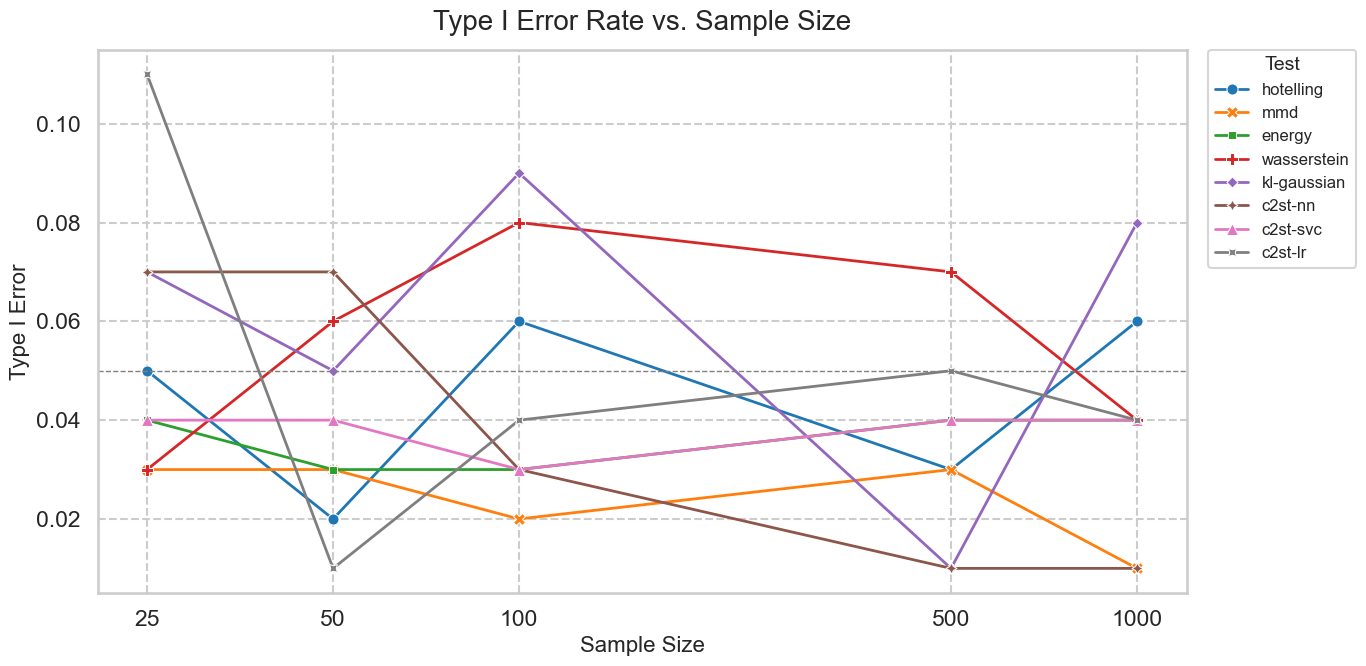

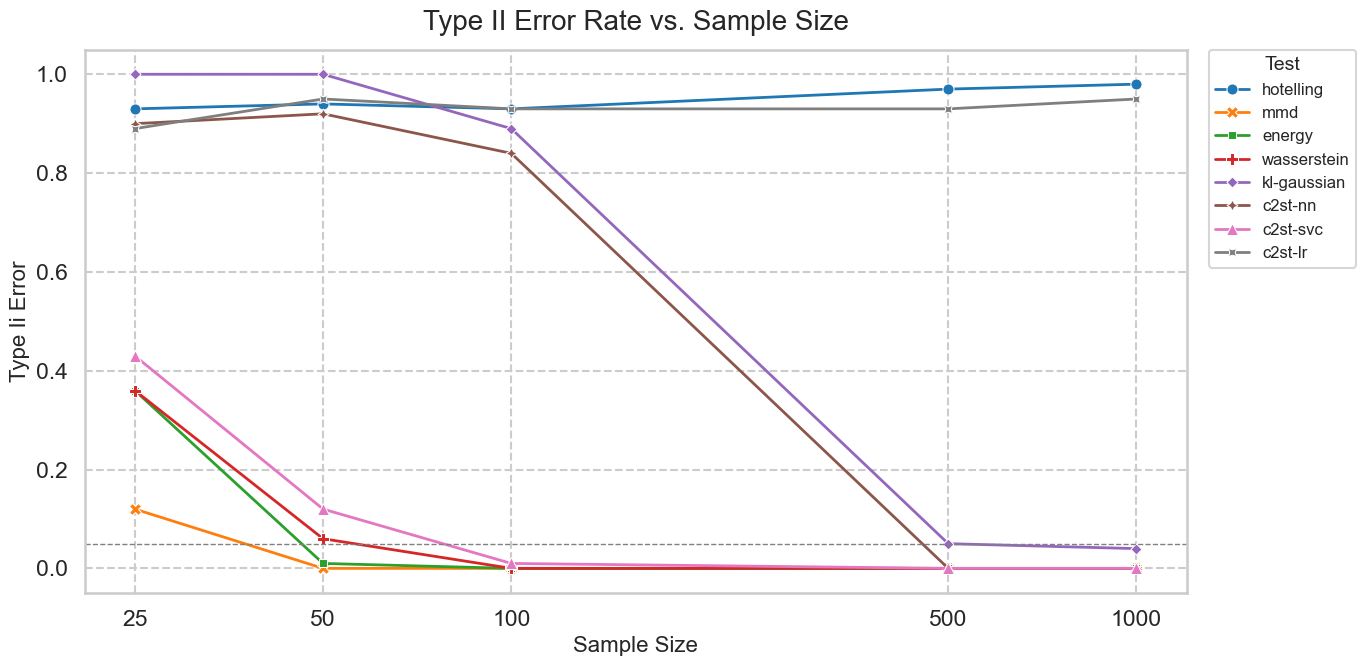

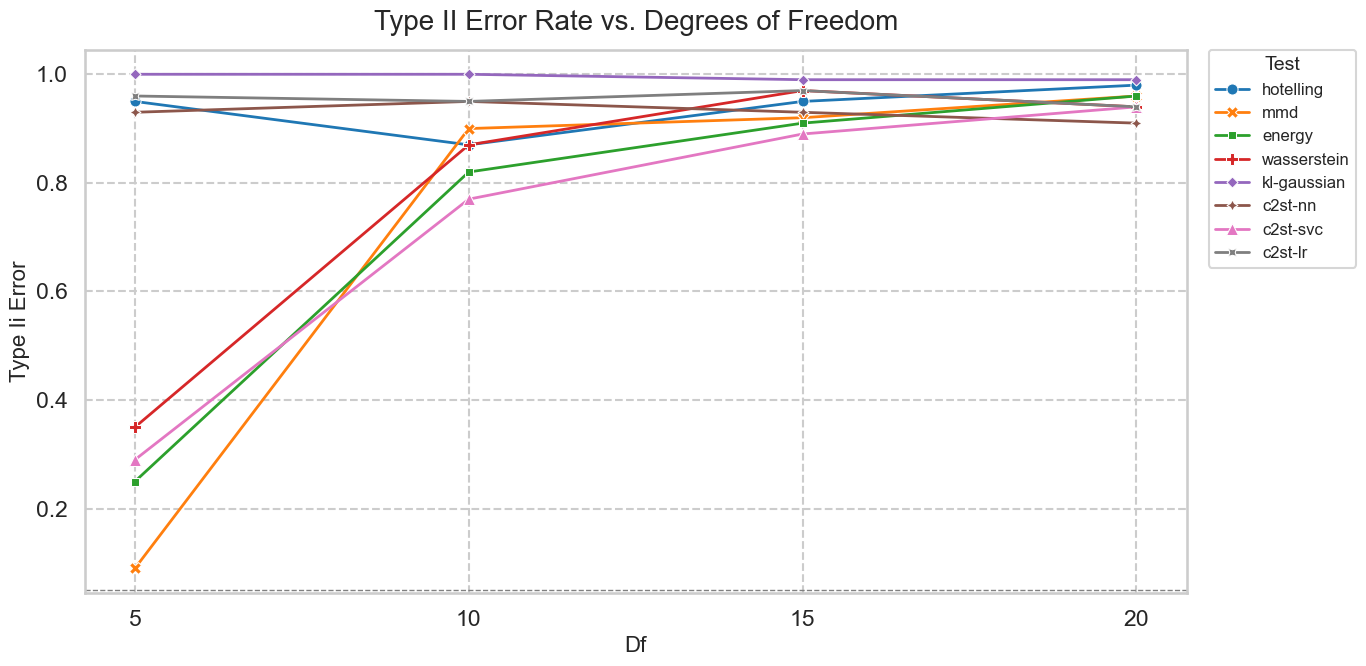

In [40]:
plot_error_vs_sample(
    type_I_error_dataframe,
    x_col="sample_size",
    error_col="type_I_error",
    title="Type I Error Rate vs. Sample Size",
    xticks=sorted(type_I_error_dataframe["sample_size"].unique())
)

plot_error_vs_sample(
    type_II_error_dataframe,
    x_col="sample_size",
    error_col="type_II_error",
    title="Type II Error Rate vs. Sample Size",
    xticks=sorted(type_II_error_dataframe["sample_size"].unique())
)

plot_error_vs_sample(
    type_II_error_dataframe_deg,
    x_col="df",
    error_col="type_II_error",
    title="Type II Error Rate vs. Degrees of Freedom",
    xticks=sorted(type_II_error_dataframe_deg["df"].unique())
)

## Save results

In [46]:
import os

out_dir = "results/"
os.makedirs(out_dir, exist_ok=True)

type_I_error_dataframe.to_csv(os.path.join(out_dir, "type_I_errors_all.csv"), index=False)
type_II_error_dataframe.to_csv(os.path.join(out_dir, "type_II_errors_all.csv"), index=False)

type_II_error_dataframe_deg.to_csv(os.path.join(out_dir, "type_II_errors_dof_all.csv"), index=False)

for df, prefix in [
    (type_I_error_dataframe, "type_I"),
    (type_II_error_dataframe, "type_II"),
    (type_II_error_dataframe_deg, "type_II_dof"),
]:
    for test_name, group in df.groupby("test_type"):
        fn = f"{prefix}_{test_name.replace('/', '_')}.csv"
        path = os.path.join(out_dir, fn)
        group.to_csv(path, index=False)

In [50]:
type_I_error_dataframe.to_csv("results/type_I_errors.csv", index=False)
type_II_error_dataframe.to_csv("results/type_II_errors.csv", index=False)
type_II_error_dataframe_deg.to_csv("results/type_II_errors_dof.csv", index=False)